In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
import logging
import os
from neuralforecast.losses.pytorch import MQLoss
# Set both HTTP and HTTPS proxies
os.environ["HTTP_PROXY"]  = "http://proxy.isoad.isogmbh.de:81"
os.environ["HTTPS_PROXY"] = "http://proxy.isoad.isogmbh.de:81"

# 1. EINMALIGER DOWNLOAD (Außerhalb der Schleife)
tickers = ['AAPL', 'SPY']
df_raw_multi = yf.download(tickers, start='2021-06-01', end='2025-01-01')

# 2. BASIS-BERECHNUNG (Log-Returns & Volumen)
df_close_log = np.log(df_raw_multi['Close'] / df_raw_multi['Close'].shift(1))
df_vol_log = np.log(df_raw_multi['Volume']).diff()

# Echte AAPL-Preise für P&L-Berechnung
aapl_open = df_raw_multi['Open']['AAPL']
aapl_close = df_raw_multi['Close']['AAPL']

# 3. DIE SCHLEIFE
test_dates = df_close_log['2024-01-01':].index
portfolio_value = 10000.0
current_pos = 0
entry_price = None
THRESHOLD = 0.000553
FEE = 0.0005
log_file = 'walk_forward_log.csv'

# Log-Header
with open(log_file, 'w') as f:
    f.write("date,pred_momentum,signal,trade_return,portfolio_value\n")

for i, today in enumerate(test_dates):
    # --- DATEN-FENSTER FÜR HEUTE ERSTELLEN ---
    df_list = []
    for t in tickers:
        mask = df_close_log.index <= today
        df_list.append(pd.DataFrame({
            'ds': df_close_log.index[mask],
            'unique_id': f'{t}_price',
            'y': df_close_log[t][mask]
        }))
        df_list.append(pd.DataFrame({
            'ds': df_vol_log.index[mask],
            'unique_id': f'{t}_vol',
            'y': df_vol_log[t][mask]
        }))

    df_step = pd.concat(df_list).dropna()

    horizon = 7
    input_size = 60
    model = PatchTST(
        h=horizon,
        input_size=input_size,
        loss=MQLoss(level=[80, 95]),
        patch_len=16,
        stride=8,
        # Architecture — correct parameter names
        encoder_layers=2,
        n_heads=4,
        hidden_size=64,
        linear_hidden_size=128,
        # Regularization
        dropout=0.1,
        head_dropout=0.1,
        max_steps=300,
        val_check_steps=300,
        early_stop_patience_steps=-1,
        accelerator='gpu',
        devices=1,
        enable_progress_bar=False,
    )

    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(df=df_step, val_size=20)

    forecast = nf.predict(df=df_step)
    # With MQLoss the median column is 'PatchTST-median'
    pred_momentum = forecast.query("unique_id == 'AAPL_price'").iloc[0]['PatchTST-median']

    # Signal Logik
    signal = 0
    if pred_momentum > THRESHOLD: signal = 1
    elif pred_momentum < -THRESHOLD: signal = -1

    # --- ABRECHNUNG MIT ECHTEN PREISEN ---
    trade_return = 0.0

    if signal != current_pos:
        # 1. Bestehende Position schließen zum heutigen Close
        if current_pos != 0 and entry_price is not None:
            close_today = aapl_close.loc[today]
            trade_return = current_pos * (close_today - entry_price) / entry_price
            portfolio_value *= (1 + trade_return)

        # 2. Kosten bei Signalwechsel (Roundtrip-Gebühr)
        portfolio_value *= (1 - FEE)

        # 3. Neue Position eröffnen zum Open des nächsten Tages
        if signal != 0 and i + 1 < len(test_dates):
            next_day = test_dates[i + 1]
            entry_price = aapl_open.loc[next_day]
        else:
            entry_price = None

        current_pos = signal

    print(f"{today.date()} | Pred: {pred_momentum:.5f} | Signal: {signal} | "
          f"Pos: {current_pos} | Return: {trade_return:+.4f} | Port: {portfolio_value:.2f}")
    with open(log_file, 'a') as f:
        f.write(f"{today.date()},{pred_momentum},{signal},{trade_return},{portfolio_value}\n")

# Letzte offene Position zum letzten Close schließen
if current_pos != 0 and entry_price is not None:
    last_close = aapl_close.loc[test_dates[-1]]
    final_return = current_pos * (last_close - entry_price) / entry_price
    portfolio_value *= (1 + final_return)
    portfolio_value *= (1 - FEE)
    print(f"\nFinal close | Return: {final_return:+.4f} | Port: {portfolio_value:.2f}€")

print(f"\n=== Endwert: {portfolio_value:.2f}€ (Start: 10000€, Rendite: {(portfolio_value/10000-1)*100:+.2f}%) ===")

[*********************100%***********************]  2 of 2 completed
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-02 | Pred: 0.00333 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9995.00


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-03 | Pred: 0.00589 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9995.00


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-04 | Pred: 0.00051 | Signal: 0 | Pos: 0 | Return: -0.0125 | Port: 9864.73


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-05 | Pred: 0.00050 | Signal: 0 | Pos: 0 | Return: +0.0000 | Port: 9864.73


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-08 | Pred: -0.00586 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9859.80


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-09 | Pred: -0.00516 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9859.80


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-10 | Pred: -0.00342 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9859.80


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-11 | Pred: -0.00167 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9859.80


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-12 | Pred: -0.00092 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9859.80


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-16 | Pred: -0.00162 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9859.80


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-17 | Pred: 0.00216 | Signal: 1 | Pos: 1 | Return: +0.0067 | Port: 9921.31


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-18 | Pred: -0.00281 | Signal: -1 | Pos: -1 | Return: +0.0136 | Port: 10051.70


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-19 | Pred: -0.00003 | Signal: 0 | Pos: 0 | Return: -0.0118 | Port: 9928.34


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-22 | Pred: -0.00007 | Signal: 0 | Pos: 0 | Return: +0.0000 | Port: 9928.34


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-23 | Pred: 0.00322 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-24 | Pred: 0.00861 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-25 | Pred: 0.00628 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-26 | Pred: 0.01160 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-29 | Pred: 0.00575 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-30 | Pred: 0.00473 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-01-31 | Pred: 0.01067 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-01 | Pred: 0.00140 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9923.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-02 | Pred: 0.00017 | Signal: 0 | Pos: 0 | Return: -0.0490 | Port: 9432.70


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-05 | Pred: -0.00501 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9427.98


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-06 | Pred: -0.00611 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9427.98


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-07 | Pred: 0.00032 | Signal: 0 | Pos: 0 | Return: -0.0136 | Port: 9294.67


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-08 | Pred: -0.00262 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9290.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-09 | Pred: -0.00086 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9290.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-12 | Pred: -0.00431 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9290.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-13 | Pred: -0.00303 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9290.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-14 | Pred: -0.00043 | Signal: 0 | Pos: 0 | Return: +0.0239 | Port: 9506.87


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-15 | Pred: 0.00105 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9502.12


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-16 | Pred: -0.00025 | Signal: 0 | Pos: 0 | Return: -0.0061 | Port: 9439.89


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-20 | Pred: 0.00128 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9435.17


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-21 | Pred: 0.00283 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9435.17


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-22 | Pred: 0.00030 | Signal: 0 | Pos: 0 | Return: +0.0134 | Port: 9556.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-23 | Pred: 0.00149 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9551.63


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-26 | Pred: 0.00220 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9551.63


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-27 | Pred: -0.00521 | Signal: -1 | Pos: -1 | Return: +0.0021 | Port: 9567.29


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-28 | Pred: 0.00461 | Signal: 1 | Pos: 1 | Return: +0.0060 | Port: 9619.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-02-29 | Pred: 0.00226 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9619.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-01 | Pred: 0.00082 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9619.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-04 | Pred: 0.00439 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9619.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-05 | Pred: 0.00635 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9619.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-06 | Pred: 0.00543 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9619.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-07 | Pred: 0.00098 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9619.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-08 | Pred: -0.00484 | Signal: -1 | Pos: -1 | Return: -0.0581 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-11 | Pred: -0.00898 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-12 | Pred: -0.00751 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-13 | Pred: -0.00623 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-14 | Pred: -0.00959 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-15 | Pred: -0.00671 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-18 | Pred: -0.00469 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-19 | Pred: -0.00857 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-20 | Pred: -0.00452 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9055.75


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-21 | Pred: 0.00475 | Signal: 1 | Pos: 1 | Return: +0.0091 | Port: 9133.39


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-22 | Pred: 0.00347 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9133.39


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-25 | Pred: 0.00250 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9133.39


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-26 | Pred: 0.00145 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9133.39


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-27 | Pred: -0.00581 | Signal: -1 | Pos: -1 | Return: +0.0090 | Port: 9211.21


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-03-28 | Pred: -0.00241 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9211.21


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-01 | Pred: -0.00230 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9211.21


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-02 | Pred: 0.00131 | Signal: 1 | Pos: 1 | Return: +0.0169 | Port: 9362.59


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-03 | Pred: -0.00221 | Signal: -1 | Pos: -1 | Return: +0.0051 | Port: 9405.59


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-04 | Pred: -0.00306 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9405.59


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-05 | Pred: -0.00644 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9405.59


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-08 | Pred: -0.00011 | Signal: 0 | Pos: 0 | Return: +0.0108 | Port: 9502.46


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-09 | Pred: -0.00242 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9497.71


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-10 | Pred: 0.00092 | Signal: 1 | Pos: 1 | Return: +0.0060 | Port: 9550.32


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-11 | Pred: -0.01263 | Signal: -1 | Pos: -1 | Return: +0.0398 | Port: 9925.47


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-12 | Pred: -0.00582 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9925.47


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-15 | Pred: -0.00574 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9925.47


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-16 | Pred: -0.00086 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9925.47


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-17 | Pred: 0.00201 | Signal: 1 | Pos: 1 | Return: +0.0359 | Port: 10276.88


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-18 | Pred: -0.00043 | Signal: 0 | Pos: 0 | Return: -0.0059 | Port: 10211.22


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-19 | Pred: 0.00133 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10206.12


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-22 | Pred: -0.00214 | Signal: -1 | Pos: -1 | Return: +0.0019 | Port: 10220.74


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-23 | Pred: -0.00825 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 10220.74


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-24 | Pred: -0.00539 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 10220.74


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-25 | Pred: -0.00437 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 10220.74


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-26 | Pred: -0.00054 | Signal: 0 | Pos: 0 | Return: -0.0239 | Port: 9971.59


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-29 | Pred: -0.01197 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9966.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-04-30 | Pred: 0.00309 | Signal: 1 | Pos: 1 | Return: +0.0173 | Port: 10134.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-01 | Pred: -0.00138 | Signal: -1 | Pos: -1 | Return: -0.0017 | Port: 10112.24


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-02 | Pred: -0.01301 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 10112.24


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-03 | Pred: -0.01788 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 10112.24


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-06 | Pred: -0.00131 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 10112.24


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-07 | Pred: 0.00027 | Signal: 0 | Pos: 0 | Return: -0.0573 | Port: 9527.74


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-08 | Pred: 0.00084 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9522.98


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-09 | Pred: 0.00206 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9522.98


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-10 | Pred: 0.00291 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9522.98


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-13 | Pred: -0.00214 | Signal: -1 | Pos: -1 | Return: +0.0218 | Port: 9725.34


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-14 | Pred: 0.00145 | Signal: 1 | Pos: 1 | Return: +0.0004 | Port: 9724.62


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-15 | Pred: -0.00378 | Signal: -1 | Pos: -1 | Return: +0.0096 | Port: 9813.38


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-16 | Pred: 0.00164 | Signal: 1 | Pos: 1 | Return: +0.0033 | Port: 9840.92


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-17 | Pred: 0.00083 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9840.92


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-20 | Pred: -0.00508 | Signal: -1 | Pos: -1 | Return: +0.0081 | Port: 9915.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-21 | Pred: 0.00231 | Signal: 1 | Pos: 1 | Return: -0.0066 | Port: 9845.10


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-22 | Pred: 0.00377 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9845.10


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-23 | Pred: 0.00525 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9845.10


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-24 | Pred: -0.00932 | Signal: -1 | Pos: -1 | Return: -0.0119 | Port: 9722.98


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-28 | Pred: 0.00023 | Signal: 0 | Pos: 0 | Return: +0.0079 | Port: 9795.25


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-29 | Pred: -0.00005 | Signal: 0 | Pos: 0 | Return: +0.0000 | Port: 9795.25


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-30 | Pred: -0.00057 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9790.35


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-05-31 | Pred: 0.00084 | Signal: 1 | Pos: 1 | Return: -0.0042 | Port: 9744.05


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-03 | Pred: -0.00137 | Signal: -1 | Pos: -1 | Return: +0.0059 | Port: 9796.23


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-04 | Pred: -0.00125 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9796.23


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-05 | Pred: 0.00323 | Signal: 1 | Pos: 1 | Return: -0.0063 | Port: 9729.46


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-06 | Pred: 0.00200 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9729.46


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-07 | Pred: 0.00040 | Signal: 0 | Pos: 0 | Return: +0.0061 | Port: 9784.23


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-10 | Pred: 0.00953 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 9779.34


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-11 | Pred: -0.01519 | Signal: -1 | Pos: -1 | Return: +0.0697 | Port: 10455.86


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-12 | Pred: -0.01217 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 10455.86


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-13 | Pred: 0.00385 | Signal: 1 | Pos: 1 | Return: -0.0331 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-14 | Pred: 0.00768 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-17 | Pred: 0.00161 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-18 | Pred: 0.00869 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-20 | Pred: 0.01064 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-21 | Pred: 0.00987 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-24 | Pred: 0.00849 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-25 | Pred: 0.00612 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10104.41


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-26 | Pred: -0.00257 | Signal: -1 | Pos: -1 | Return: -0.0028 | Port: 10071.02


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-27 | Pred: 0.00008 | Signal: 0 | Pos: 0 | Return: +0.0027 | Port: 10093.65


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-06-28 | Pred: 0.00224 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10088.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-01 | Pred: -0.00429 | Signal: -1 | Pos: -1 | Return: +0.0220 | Port: 10305.11


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-02 | Pred: 0.00065 | Signal: 1 | Pos: 1 | Return: -0.0191 | Port: 10103.63


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-03 | Pred: 0.00109 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10103.63


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-05 | Pred: -0.00890 | Signal: -1 | Pos: -1 | Return: +0.0288 | Port: 10389.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-08 | Pred: 0.00167 | Signal: 1 | Pos: 1 | Return: -0.0032 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-09 | Pred: 0.00155 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-10 | Pred: 0.00215 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-11 | Pred: 0.00420 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-12 | Pred: 0.00956 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-15 | Pred: 0.00781 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-16 | Pred: 0.01405 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-17 | Pred: 0.00967 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-18 | Pred: 0.01068 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-19 | Pred: 0.00722 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-22 | Pred: 0.00821 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-23 | Pred: 0.00420 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-24 | Pred: 0.00683 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-25 | Pred: 0.01224 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-26 | Pred: 0.00714 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-29 | Pred: 0.00949 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10351.03


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-30 | Pred: 0.00000 | Signal: 0 | Pos: 0 | Return: -0.0401 | Port: 9931.44


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-07-31 | Pred: -0.00267 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 9926.47


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-01 | Pred: 0.00050 | Signal: 0 | Pos: 0 | Return: +0.0268 | Port: 10187.27


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-02 | Pred: 0.00252 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10182.17


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-05 | Pred: -0.00409 | Signal: -1 | Pos: -1 | Return: +0.0511 | Port: 10697.46


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-06 | Pred: 0.00555 | Signal: 1 | Pos: 1 | Return: -0.0094 | Port: 10591.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-07 | Pred: 0.00074 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10591.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-08 | Pred: 0.00168 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10591.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-09 | Pred: 0.00210 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10591.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-12 | Pred: 0.00130 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 10591.60


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-13 | Pred: -0.00200 | Signal: -1 | Pos: -1 | Return: +0.0707 | Port: 11334.67


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-14 | Pred: 0.00451 | Signal: 1 | Pos: 1 | Return: -0.0052 | Port: 11269.93


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-15 | Pred: 0.00375 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11269.93


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-16 | Pred: -0.00070 | Signal: -1 | Pos: -1 | Return: +0.0065 | Port: 11337.02


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-19 | Pred: 0.00556 | Signal: 1 | Pos: 1 | Return: -0.0008 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-20 | Pred: 0.00123 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-21 | Pred: 0.00795 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-22 | Pred: 0.00831 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-23 | Pred: 0.00566 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-26 | Pred: 0.00402 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-27 | Pred: 0.00120 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-28 | Pred: 0.00228 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-29 | Pred: 0.00440 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11322.82


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-08-30 | Pred: 0.00042 | Signal: 0 | Pos: 0 | Return: +0.0143 | Port: 11479.07


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-03 | Pred: 0.00302 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11473.33


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-04 | Pred: 0.00124 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11473.33


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-05 | Pred: 0.00036 | Signal: 0 | Pos: 0 | Return: +0.0032 | Port: 11504.84


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-06 | Pred: 0.00066 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11499.09


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-09 | Pred: -0.00173 | Signal: -1 | Pos: -1 | Return: +0.0004 | Port: 11498.02


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-10 | Pred: 0.00201 | Signal: 1 | Pos: 1 | Return: -0.0054 | Port: 11429.80


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-11 | Pred: 0.00019 | Signal: 0 | Pos: 0 | Return: +0.0054 | Port: 11485.99


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-12 | Pred: 0.00114 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11480.25


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-13 | Pred: -0.00139 | Signal: -1 | Pos: -1 | Return: -0.0048 | Port: 11419.08


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-16 | Pred: -0.00427 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11419.08


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-17 | Pred: 0.00274 | Signal: 1 | Pos: 1 | Return: -0.0012 | Port: 11400.19


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-18 | Pred: 0.00049 | Signal: 0 | Pos: 0 | Return: +0.0144 | Port: 11558.96


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-19 | Pred: -0.01068 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11553.18


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-20 | Pred: -0.00292 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11553.18


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-23 | Pred: 0.00528 | Signal: 1 | Pos: 1 | Return: +0.0152 | Port: 11723.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-24 | Pred: 0.00721 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11723.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-25 | Pred: 0.01056 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11723.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-26 | Pred: 0.00434 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11723.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-27 | Pred: 0.00083 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11723.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-09-30 | Pred: -0.00415 | Signal: -1 | Pos: -1 | Return: +0.0190 | Port: 11940.20


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-01 | Pred: 0.00656 | Signal: 1 | Pos: 1 | Return: +0.0144 | Port: 12106.34


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-02 | Pred: 0.00149 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12106.34


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-03 | Pred: -0.00191 | Signal: -1 | Pos: -1 | Return: -0.0010 | Port: 12088.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-04 | Pred: -0.00360 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 12088.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-07 | Pred: 0.00118 | Signal: 1 | Pos: 1 | Return: +0.0272 | Port: 12411.69


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-08 | Pred: -0.00774 | Signal: -1 | Pos: -1 | Return: +0.0066 | Port: 12486.78


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-09 | Pred: -0.00671 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 12486.78


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-10 | Pred: -0.00246 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 12486.78


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-11 | Pred: -0.00021 | Signal: 0 | Pos: 0 | Return: -0.0103 | Port: 12351.98


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-14 | Pred: -0.00672 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 12345.81


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-15 | Pred: -0.00476 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 12345.81


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-16 | Pred: -0.00127 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 12345.81


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-17 | Pred: 0.00102 | Signal: 1 | Pos: 1 | Return: +0.0062 | Port: 12416.76


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-18 | Pred: -0.00199 | Signal: -1 | Pos: -1 | Return: -0.0050 | Port: 12348.54


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-21 | Pred: 0.00460 | Signal: 1 | Pos: 1 | Return: -0.0087 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-22 | Pred: 0.00368 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-23 | Pred: 0.00297 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-24 | Pred: 0.00098 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-25 | Pred: 0.00186 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-28 | Pred: 0.00585 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-29 | Pred: 0.00426 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-30 | Pred: 0.00257 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-10-31 | Pred: 0.00591 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-01 | Pred: 0.00653 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-04 | Pred: 0.00449 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12235.50


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-05 | Pred: -0.00185 | Signal: -1 | Pos: -1 | Return: -0.0446 | Port: 11683.51


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-06 | Pred: 0.00031 | Signal: 0 | Pos: 0 | Return: -0.0005 | Port: 11671.90


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-07 | Pred: -0.00878 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11666.06


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-08 | Pred: -0.00094 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11666.06


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-11 | Pred: -0.00100 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11666.06


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-12 | Pred: -0.00455 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11666.06


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-13 | Pred: -0.00111 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11666.06


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-14 | Pred: -0.00044 | Signal: 0 | Pos: 0 | Return: -0.0046 | Port: 11606.33


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-15 | Pred: 0.00408 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11600.53


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-18 | Pred: -0.00329 | Signal: -1 | Pos: -1 | Return: +0.0123 | Port: 11737.31


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-19 | Pred: 0.00091 | Signal: 1 | Pos: 1 | Return: -0.0057 | Port: 11664.26


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-20 | Pred: 0.00268 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11664.26


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-21 | Pred: 0.00339 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11664.26


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-22 | Pred: -0.00036 | Signal: 0 | Pos: 0 | Return: +0.0079 | Port: 11750.95


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-25 | Pred: -0.00228 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11745.07


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-26 | Pred: -0.00200 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11745.07


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-27 | Pred: 0.00329 | Signal: 1 | Pos: 1 | Return: -0.0069 | Port: 11658.71


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-11-29 | Pred: -0.00184 | Signal: -1 | Pos: -1 | Return: +0.0107 | Port: 11777.94


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-02 | Pred: -0.00036 | Signal: 0 | Pos: 0 | Return: -0.0098 | Port: 11656.94


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-03 | Pred: -0.00364 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11651.11


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-04 | Pred: -0.00364 | Signal: -1 | Pos: -1 | Return: +0.0000 | Port: 11651.11


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-05 | Pred: 0.00185 | Signal: 1 | Pos: 1 | Return: -0.0007 | Port: 11637.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-06 | Pred: 0.00457 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11637.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-09 | Pred: 0.00175 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11637.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-10 | Pred: 0.00186 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11637.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-11 | Pred: 0.00379 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11637.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-12 | Pred: 0.00003 | Signal: 0 | Pos: 0 | Return: +0.0208 | Port: 11873.13


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-13 | Pred: 0.00141 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 11867.19


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-16 | Pred: -0.00030 | Signal: 0 | Pos: 0 | Return: +0.0123 | Port: 12007.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-17 | Pred: -0.00020 | Signal: 0 | Pos: 0 | Return: +0.0000 | Port: 12007.14


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-18 | Pred: 0.00082 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12001.13


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-19 | Pred: 0.00233 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12001.13


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-20 | Pred: -0.00394 | Signal: -1 | Pos: -1 | Return: +0.0282 | Port: 12333.90


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-23 | Pred: 0.00097 | Signal: 1 | Pos: 1 | Return: -0.0020 | Port: 12303.54


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-24 | Pred: -0.00426 | Signal: -1 | Pos: -1 | Return: +0.0106 | Port: 12427.83


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-26 | Pred: 0.00389 | Signal: 1 | Pos: 1 | Return: -0.0032 | Port: 12381.69


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-27 | Pred: 0.00478 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12381.69


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is 

2024-12-30 | Pred: 0.00528 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12381.69


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss            │      5 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │ 84.2 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 84.2 K                                                                                           
Non-trainable params: 7                                                                                            
Total params: 84.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2024-12-31 | Pred: 0.00403 | Signal: 1 | Pos: 1 | Return: +0.0000 | Port: 12381.69

Final close | Return: -0.0287 | Port: 12019.83€

=== Endwert: 12019.83€ (Start: 10000€, Rendite: +20.20%) ===


/home/aidev/patchtst_timeseries/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


[*********************100%***********************]  1 of 1 completed


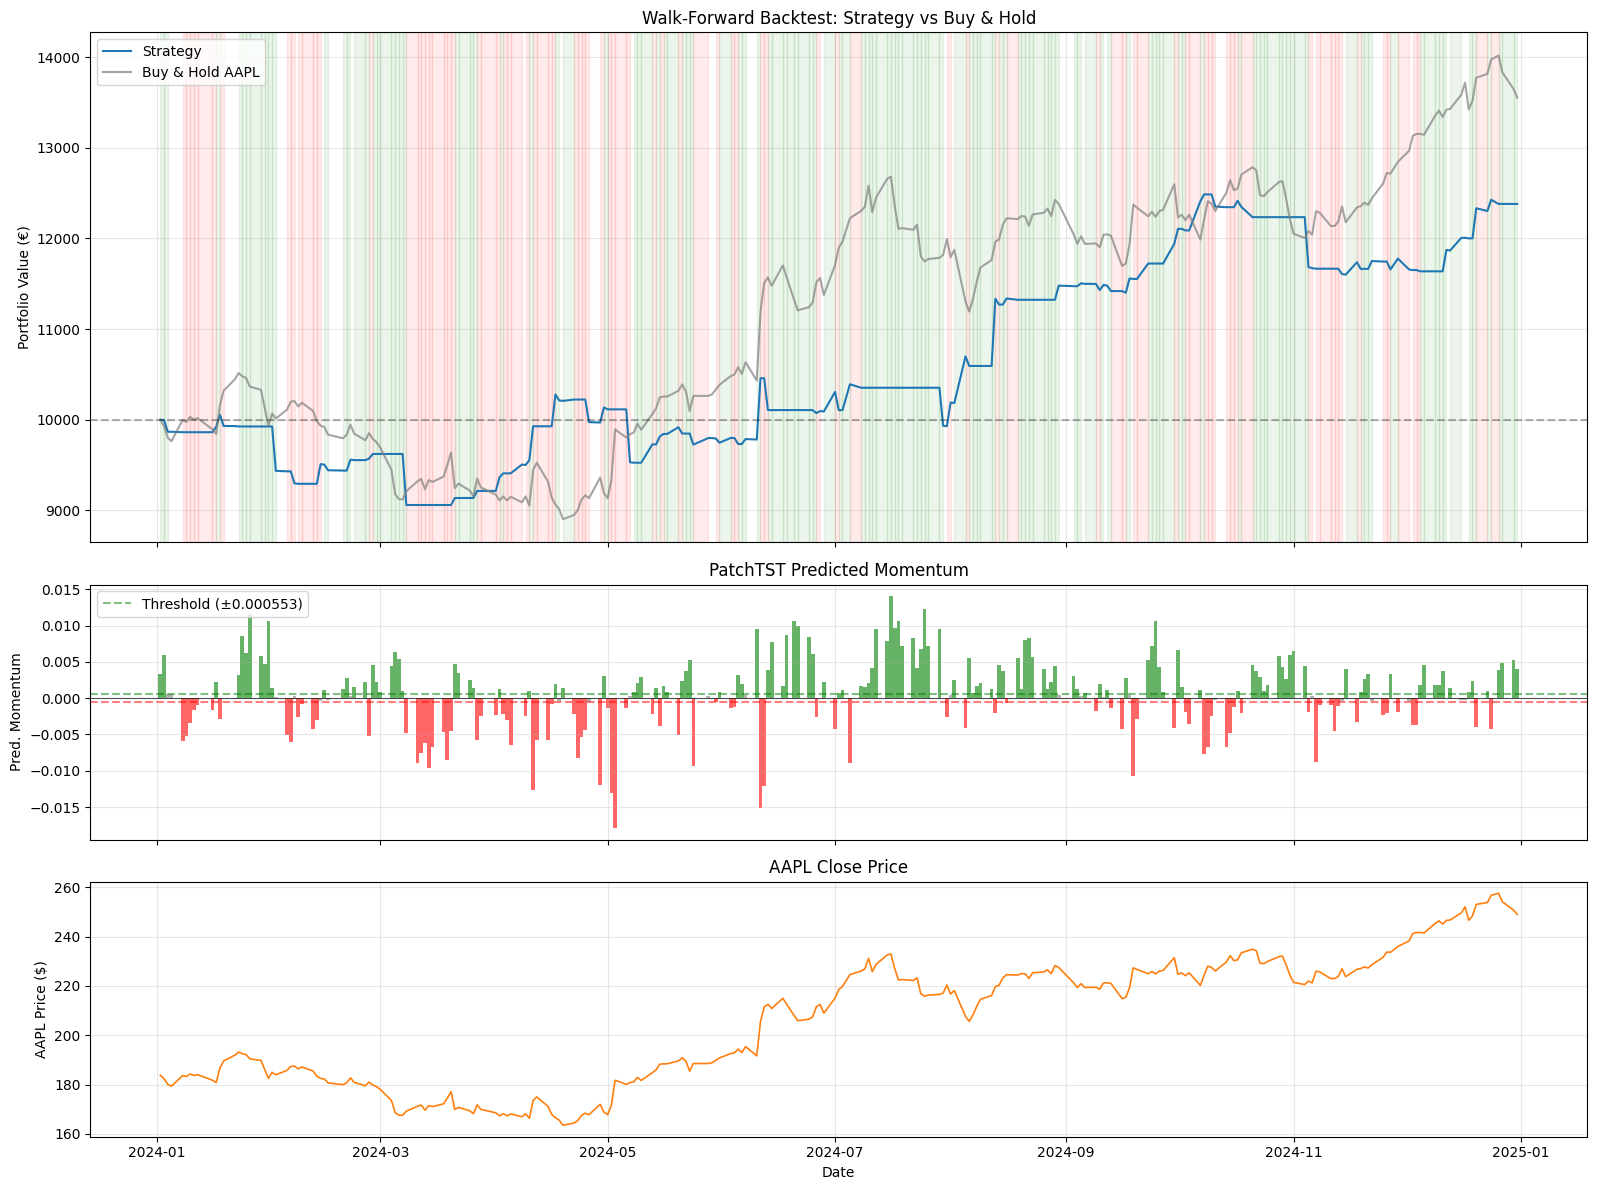

Strategy Return:   +23.82%
Buy & Hold Return: +35.56%
Signal Changes:    115
Long/Short/Flat:   133 / 88 / 31 days


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
os.environ["HTTP_PROXY"]  = "http://proxy.isoad.isogmbh.de:81"
os.environ["HTTPS_PROXY"] = "http://proxy.isoad.isogmbh.de:81"

# Log einlesen
df_log = pd.read_csv('walk_forward_log.csv', parse_dates=['date'], index_col='date')

# AAPL Close-Preise für den gleichen Zeitraum
df_aapl = yf.download('AAPL', start='2021-06-01', end='2025-01-01')
aapl_close = df_aapl['Close'].squeeze()
aapl_bt = aapl_close.loc[df_log.index]

# Buy & Hold normalisiert auf gleichen Startwert
bh_normalized = aapl_bt / aapl_bt.iloc[0] * 10000

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1, 1]})

# --- Plot 1: Portfolio P&L vs Buy & Hold ---
ax1 = axes[0]
ax1.plot(df_log.index, df_log['portfolio_value'], label='Strategy', linewidth=1.5, color='tab:blue')
ax1.plot(bh_normalized.index, bh_normalized.values, label='Buy & Hold AAPL', linewidth=1.5, color='tab:gray', alpha=0.7)
ax1.axhline(10000, color='black', linestyle='--', alpha=0.3)
ax1.set_ylabel('Portfolio Value (€)')
ax1.set_title('Walk-Forward Backtest: Strategy vs Buy & Hold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Signals als Hintergrundfarbe
for j in range(len(df_log) - 1):
    sig = df_log['signal'].iloc[j]
    if sig == 1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='green')
    elif sig == -1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='red')

# --- Plot 2: Predicted Momentum + Threshold ---
ax2 = axes[1]
colors = ['green' if s == 1 else 'red' if s == -1 else 'gray' for s in df_log['signal']]
ax2.bar(df_log.index, df_log['pred_momentum'], color=colors, alpha=0.6, width=1)
ax2.axhline(0.000553, color='green', linestyle='--', alpha=0.5, label=f'Threshold (±{0.000553})')
ax2.axhline(-0.000553, color='red', linestyle='--', alpha=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Pred. Momentum')
ax2.set_title('PatchTST Predicted Momentum')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# --- Plot 3: AAPL Kurs ---
ax3 = axes[2]
ax3.plot(aapl_bt.index, aapl_bt.values, color='tab:orange', linewidth=1.2)
ax3.set_ylabel('AAPL Price ($)')
ax3.set_title('AAPL Close Price')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('walk_forward_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistiken
total_return = (df_log['portfolio_value'].iloc[-1] / 10000 - 1) * 100
bh_return = (aapl_bt.iloc[-1] / aapl_bt.iloc[0] - 1) * 100
n_trades = (df_log['signal'].diff().fillna(0) != 0).sum()
long_days = (df_log['signal'] == 1).sum()
short_days = (df_log['signal'] == -1).sum()
flat_days = (df_log['signal'] == 0).sum()

print(f"Strategy Return:   {total_return:+.2f}%")
print(f"Buy & Hold Return: {bh_return:+.2f}%")
print(f"Signal Changes:    {n_trades}")
print(f"Long/Short/Flat:   {long_days} / {short_days} / {flat_days} days")